In [ ]:
# This Colab notebook uses code from various sources to train and test the MedT model on the Medical Decathlon dataset.

# The MedT model implementation is sourced from:
# https://github.com/jeya-maria-jose/Medical-Transformer

# The dataloader and related functions are sourced from:
# https://github.com/shailensobhee/medical-decathlon

# The Medical Decathlon dataset is sourced from:
# http://medicaldecathlon.com/

# Please refer to the original repositories for further information and attributions.

In [ ]:
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Apr 15 22:47:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pdb
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import pdb
import matplotlib.pyplot as plt

import random

import numpy as np
import os
from torch.autograd import Variable
import cv2

In [ ]:
def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [ ]:
class qkv_transform(nn.Conv1d):
    """Conv1d for qkv_transform"""

In [ ]:
class AxialAttention(nn.Module):
    def __init__(self, in_planes, out_planes, groups=8, kernel_size=56,
                 stride=1, bias=False, width=False):
        assert (in_planes % groups == 0) and (out_planes % groups == 0)
        super(AxialAttention, self).__init__()
        self.in_planes = in_planes
        self.out_planes = out_planes
        self.groups = groups
        self.group_planes = out_planes // groups
        self.kernel_size = kernel_size
        self.stride = stride
        self.bias = bias
        self.width = width

        # Multi-head self attention
        self.qkv_transform = qkv_transform(in_planes, out_planes * 2, kernel_size=1, stride=1,
                                           padding=0, bias=False)
        self.bn_qkv = nn.BatchNorm1d(out_planes * 2)
        self.bn_similarity = nn.BatchNorm2d(groups * 3)

        self.bn_output = nn.BatchNorm1d(out_planes * 2)

        # Position embedding
        self.relative = nn.Parameter(torch.randn(self.group_planes * 2, kernel_size * 2 - 1), requires_grad=True)
        query_index = torch.arange(kernel_size).unsqueeze(0)
        key_index = torch.arange(kernel_size).unsqueeze(1)
        relative_index = key_index - query_index + kernel_size - 1
        self.register_buffer('flatten_index', relative_index.view(-1))
        if stride > 1:
            self.pooling = nn.AvgPool2d(stride, stride=stride)

        self.reset_parameters()

    def forward(self, x):
        # pdb.set_trace()
        if self.width:
            x = x.permute(0, 2, 1, 3)
        else:
            x = x.permute(0, 3, 1, 2)  # N, W, C, H
        N, W, C, H = x.shape
        x = x.contiguous().view(N * W, C, H)

        # Transformations
        qkv = self.bn_qkv(self.qkv_transform(x))
        q, k, v = torch.split(qkv.reshape(N * W, self.groups, self.group_planes * 2, H), [self.group_planes // 2, self.group_planes // 2, self.group_planes], dim=2)

        # Calculate position embedding
        all_embeddings = torch.index_select(self.relative, 1, self.flatten_index).view(self.group_planes * 2, self.kernel_size, self.kernel_size)
        q_embedding, k_embedding, v_embedding = torch.split(all_embeddings, [self.group_planes // 2, self.group_planes // 2, self.group_planes], dim=0)

        qr = torch.einsum('bgci,cij->bgij', q, q_embedding)
        kr = torch.einsum('bgci,cij->bgij', k, k_embedding).transpose(2, 3)

        qk = torch.einsum('bgci, bgcj->bgij', q, k)

        stacked_similarity = torch.cat([qk, qr, kr], dim=1)
        stacked_similarity = self.bn_similarity(stacked_similarity).view(N * W, 3, self.groups, H, H).sum(dim=1)
        #stacked_similarity = self.bn_qr(qr) + self.bn_kr(kr) + self.bn_qk(qk)
        # (N, groups, H, H, W)
        similarity = F.softmax(stacked_similarity, dim=3)
        sv = torch.einsum('bgij,bgcj->bgci', similarity, v)
        sve = torch.einsum('bgij,cij->bgci', similarity, v_embedding)
        stacked_output = torch.cat([sv, sve], dim=-1).view(N * W, self.out_planes * 2, H)
        output = self.bn_output(stacked_output).view(N, W, self.out_planes, 2, H).sum(dim=-2)

        if self.width:
            output = output.permute(0, 2, 1, 3)
        else:
            output = output.permute(0, 2, 3, 1)

        if self.stride > 1:
            output = self.pooling(output)

        return output

    def reset_parameters(self):
        self.qkv_transform.weight.data.normal_(0, math.sqrt(1. / self.in_planes))
        #nn.init.uniform_(self.relative, -0.1, 0.1)
        nn.init.normal_(self.relative, 0., math.sqrt(1. / self.group_planes))

class AxialAttention_dynamic(nn.Module):
    def __init__(self, in_planes, out_planes, groups=8, kernel_size=56,
                 stride=1, bias=False, width=False):
        assert (in_planes % groups == 0) and (out_planes % groups == 0)
        super(AxialAttention_dynamic, self).__init__()
        self.in_planes = in_planes
        self.out_planes = out_planes
        self.groups = groups
        self.group_planes = out_planes // groups
        self.kernel_size = kernel_size
        self.stride = stride
        self.bias = bias
        self.width = width

        # Multi-head self attention
        self.qkv_transform = qkv_transform(in_planes, out_planes * 2, kernel_size=1, stride=1,
                                           padding=0, bias=False)
        self.bn_qkv = nn.BatchNorm1d(out_planes * 2)
        self.bn_similarity = nn.BatchNorm2d(groups * 3)
        self.bn_output = nn.BatchNorm1d(out_planes * 2)

        # Priority on encoding

        ## Initial values

        self.f_qr = nn.Parameter(torch.tensor(0.1),  requires_grad=False)
        self.f_kr = nn.Parameter(torch.tensor(0.1),  requires_grad=False)
        self.f_sve = nn.Parameter(torch.tensor(0.1),  requires_grad=False)
        self.f_sv = nn.Parameter(torch.tensor(1.0),  requires_grad=False)


        # Position embedding
        self.relative = nn.Parameter(torch.randn(self.group_planes * 2, kernel_size * 2 - 1), requires_grad=True)
        query_index = torch.arange(kernel_size).unsqueeze(0)
        key_index = torch.arange(kernel_size).unsqueeze(1)
        relative_index = key_index - query_index + kernel_size - 1
        self.register_buffer('flatten_index', relative_index.view(-1))
        if stride > 1:
            self.pooling = nn.AvgPool2d(stride, stride=stride)

        self.reset_parameters()
        # self.print_para()

    def forward(self, x):
        if self.width:
            x = x.permute(0, 2, 1, 3)
        else:
            x = x.permute(0, 3, 1, 2)  # N, W, C, H
        N, W, C, H = x.shape
        x = x.contiguous().view(N * W, C, H)

        # Transformations
        qkv = self.bn_qkv(self.qkv_transform(x))
        q, k, v = torch.split(qkv.reshape(N * W, self.groups, self.group_planes * 2, H), [self.group_planes // 2, self.group_planes // 2, self.group_planes], dim=2)

        # Calculate position embedding
        all_embeddings = torch.index_select(self.relative, 1, self.flatten_index).view(self.group_planes * 2, self.kernel_size, self.kernel_size)
        q_embedding, k_embedding, v_embedding = torch.split(all_embeddings, [self.group_planes // 2, self.group_planes // 2, self.group_planes], dim=0)
        qr = torch.einsum('bgci,cij->bgij', q, q_embedding)
        kr = torch.einsum('bgci,cij->bgij', k, k_embedding).transpose(2, 3)
        qk = torch.einsum('bgci, bgcj->bgij', q, k)


        # multiply by factors
        qr = torch.mul(qr, self.f_qr)
        kr = torch.mul(kr, self.f_kr)

        stacked_similarity = torch.cat([qk, qr, kr], dim=1)
        stacked_similarity = self.bn_similarity(stacked_similarity).view(N * W, 3, self.groups, H, H).sum(dim=1)
        #stacked_similarity = self.bn_qr(qr) + self.bn_kr(kr) + self.bn_qk(qk)
        # (N, groups, H, H, W)
        similarity = F.softmax(stacked_similarity, dim=3)
        sv = torch.einsum('bgij,bgcj->bgci', similarity, v)
        sve = torch.einsum('bgij,cij->bgci', similarity, v_embedding)

        # multiply by factors
        sv = torch.mul(sv, self.f_sv)
        sve = torch.mul(sve, self.f_sve)

        stacked_output = torch.cat([sv, sve], dim=-1).view(N * W, self.out_planes * 2, H)
        output = self.bn_output(stacked_output).view(N, W, self.out_planes, 2, H).sum(dim=-2)

        if self.width:
            output = output.permute(0, 2, 1, 3)
        else:
            output = output.permute(0, 2, 3, 1)

        if self.stride > 1:
            output = self.pooling(output)

        return output
    def reset_parameters(self):
        self.qkv_transform.weight.data.normal_(0, math.sqrt(1. / self.in_planes))
        #nn.init.uniform_(self.relative, -0.1, 0.1)
        nn.init.normal_(self.relative, 0., math.sqrt(1. / self.group_planes))

class AxialAttention_wopos(nn.Module):
    def __init__(self, in_planes, out_planes, groups=8, kernel_size=56,
                 stride=1, bias=False, width=False):
        assert (in_planes % groups == 0) and (out_planes % groups == 0)
        super(AxialAttention_wopos, self).__init__()
        self.in_planes = in_planes
        self.out_planes = out_planes
        self.groups = groups
        self.group_planes = out_planes // groups
        self.kernel_size = kernel_size
        self.stride = stride
        self.bias = bias
        self.width = width

        # Multi-head self attention
        self.qkv_transform = qkv_transform(in_planes, out_planes * 2, kernel_size=1, stride=1,
                                           padding=0, bias=False)
        self.bn_qkv = nn.BatchNorm1d(out_planes * 2)
        self.bn_similarity = nn.BatchNorm2d(groups )

        self.bn_output = nn.BatchNorm1d(out_planes * 1)

        if stride > 1:
            self.pooling = nn.AvgPool2d(stride, stride=stride)

        self.reset_parameters()

    def forward(self, x):
        if self.width:
            x = x.permute(0, 2, 1, 3)
        else:
            x = x.permute(0, 3, 1, 2)  # N, W, C, H
        N, W, C, H = x.shape
        x = x.contiguous().view(N * W, C, H)

        # Transformations
        qkv = self.bn_qkv(self.qkv_transform(x))
        q, k, v = torch.split(qkv.reshape(N * W, self.groups, self.group_planes * 2, H), [self.group_planes // 2, self.group_planes // 2, self.group_planes], dim=2)

        qk = torch.einsum('bgci, bgcj->bgij', q, k)

        stacked_similarity = self.bn_similarity(qk).reshape(N * W, 1, self.groups, H, H).sum(dim=1).contiguous()

        similarity = F.softmax(stacked_similarity, dim=3)
        sv = torch.einsum('bgij,bgcj->bgci', similarity, v)

        sv = sv.reshape(N*W,self.out_planes * 1, H).contiguous()
        output = self.bn_output(sv).reshape(N, W, self.out_planes, 1, H).sum(dim=-2).contiguous()


        if self.width:
            output = output.permute(0, 2, 1, 3)
        else:
            output = output.permute(0, 2, 3, 1)

        if self.stride > 1:
            output = self.pooling(output)

        return output

    def reset_parameters(self):
        self.qkv_transform.weight.data.normal_(0, math.sqrt(1. / self.in_planes))
        #nn.init.uniform_(self.relative, -0.1, 0.1)
        # nn.init.normal_(self.relative, 0., math.sqrt(1. / self.group_planes))

#end of attn definition

class AxialBlock(nn.Module):
    expansion = 2

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None, kernel_size=56):
        super(AxialBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.))
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv_down = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.hight_block = AxialAttention(width, width, groups=groups, kernel_size=kernel_size)
        self.width_block = AxialAttention(width, width, groups=groups, kernel_size=kernel_size, stride=stride, width=True)
        self.conv_up = conv1x1(width, planes * self.expansion)
        self.bn2 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv_down(x)
        out = self.bn1(out)
        out = self.relu(out)
        # print(out.shape)
        out = self.hight_block(out)
        out = self.width_block(out)
        out = self.relu(out)

        out = self.conv_up(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class AxialBlock_dynamic(nn.Module):
    expansion = 2

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None, kernel_size=56):
        super(AxialBlock_dynamic, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.))
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv_down = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.hight_block = AxialAttention_dynamic(width, width, groups=groups, kernel_size=kernel_size)
        self.width_block = AxialAttention_dynamic(width, width, groups=groups, kernel_size=kernel_size, stride=stride, width=True)
        self.conv_up = conv1x1(width, planes * self.expansion)
        self.bn2 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv_down(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.hight_block(out)
        out = self.width_block(out)
        out = self.relu(out)

        out = self.conv_up(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class AxialBlock_wopos(nn.Module):
    expansion = 2

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None, kernel_size=56):
        super(AxialBlock_wopos, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        # print(kernel_size)
        width = int(planes * (base_width / 64.))
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv_down = conv1x1(inplanes, width)
        self.conv1 = nn.Conv2d(width, width, kernel_size = 1)
        self.bn1 = norm_layer(width)
        self.hight_block = AxialAttention_wopos(width, width, groups=groups, kernel_size=kernel_size)
        self.width_block = AxialAttention_wopos(width, width, groups=groups, kernel_size=kernel_size, stride=stride, width=True)
        self.conv_up = conv1x1(width, planes * self.expansion)
        self.bn2 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        # pdb.set_trace()

        out = self.conv_down(x)
        out = self.bn1(out)
        out = self.relu(out)
        # print(out.shape)
        out = self.hight_block(out)
        out = self.width_block(out)

        out = self.relu(out)

        out = self.conv_up(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


#end of block definition

In [ ]:
class medt_net(nn.Module):

    def __init__(self, block, block_2, layers, num_classes=2, zero_init_residual=True,
                 groups=8, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None, s=0.125, img_size = 128,imgchan = 1):
        super(medt_net, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = int(64 * s)
        self.dilation = 1
        if replace_stride_with_dilation is None:
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(imgchan, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.conv2 = nn.Conv2d(self.inplanes, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv3 = nn.Conv2d(128, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.bn2 = norm_layer(128)
        self.bn3 = norm_layer(self.inplanes)
        # self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        # self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, int(128 * s), layers[0], kernel_size= (img_size//2))
        self.layer2 = self._make_layer(block, int(256 * s), layers[1], stride=2, kernel_size=(img_size//2),
                                       dilate=replace_stride_with_dilation[0])
        # self.layer3 = self._make_layer(block, int(512 * s), layers[2], stride=2, kernel_size=(img_size//4),
        #                                dilate=replace_stride_with_dilation[1])
        # self.layer4 = self._make_layer(block, int(1024 * s), layers[3], stride=2, kernel_size=(img_size//8),
        #                                dilate=replace_stride_with_dilation[2])

        # Decoder
        # self.decoder1 = nn.Conv2d(int(1024 *2*s)      ,        int(1024*2*s), kernel_size=3, stride=2, padding=1)
        # self.decoder2 = nn.Conv2d(int(1024  *2*s)     , int(1024*s), kernel_size=3, stride=1, padding=1)
        # self.decoder3 = nn.Conv2d(int(1024*s),  int(512*s), kernel_size=3, stride=1, padding=1)
        self.decoder4 = nn.Conv2d(int(512*s) ,  int(256*s), kernel_size=3, stride=1, padding=1)
        self.decoder5 = nn.Conv2d(int(256*s) , int(128*s) , kernel_size=3, stride=1, padding=1)
        self.adjust   = nn.Conv2d(int(128*s) , num_classes, kernel_size=1, stride=1, padding=0)
        self.soft     = nn.Softmax(dim=1)


        self.conv1_p = nn.Conv2d(imgchan, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.conv2_p = nn.Conv2d(self.inplanes,128, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.conv3_p = nn.Conv2d(128, self.inplanes, kernel_size=3, stride=1, padding=1,
                               bias=False)
        # self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1_p = norm_layer(self.inplanes)
        self.bn2_p = norm_layer(128)
        self.bn3_p = norm_layer(self.inplanes)

        self.relu_p = nn.ReLU(inplace=True)

        img_size_p = img_size // 4

        self.layer1_p = self._make_layer(block_2, int(128 * s), layers[0], kernel_size= (img_size_p//2))
        self.layer2_p = self._make_layer(block_2, int(256 * s), layers[1], stride=2, kernel_size=(img_size_p//2),
                                       dilate=replace_stride_with_dilation[0])
        self.layer3_p = self._make_layer(block_2, int(512 * s), layers[2], stride=2, kernel_size=(img_size_p//4),
                                       dilate=replace_stride_with_dilation[1])
        self.layer4_p = self._make_layer(block_2, int(1024 * s), layers[3], stride=2, kernel_size=(img_size_p//8),
                                       dilate=replace_stride_with_dilation[2])

        # Decoder
        self.decoder1_p = nn.Conv2d(int(1024 *2*s)      ,        int(1024*2*s), kernel_size=3, stride=2, padding=1)
        self.decoder2_p = nn.Conv2d(int(1024  *2*s)     , int(1024*s), kernel_size=3, stride=1, padding=1)
        self.decoder3_p = nn.Conv2d(int(1024*s),  int(512*s), kernel_size=3, stride=1, padding=1)
        self.decoder4_p = nn.Conv2d(int(512*s) ,  int(256*s), kernel_size=3, stride=1, padding=1)
        self.decoder5_p = nn.Conv2d(int(256*s) , int(128*s) , kernel_size=3, stride=1, padding=1)

        self.decoderf = nn.Conv2d(int(128*s) , int(128*s) , kernel_size=3, stride=1, padding=1)
        self.adjust_p   = nn.Conv2d(int(128*s) , num_classes, kernel_size=1, stride=1, padding=0)
        self.soft_p     = nn.Softmax(dim=1)


    def _make_layer(self, block, planes, blocks, kernel_size=56, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, groups=self.groups,
                            base_width=self.base_width, dilation=previous_dilation,
                            norm_layer=norm_layer, kernel_size=kernel_size))
        self.inplanes = planes * block.expansion
        if stride != 1:
            kernel_size = kernel_size // 2

        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer, kernel_size=kernel_size))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):

        xin = x.clone()
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        # x = F.max_pool2d(x,2,2)
        x = self.relu(x)

        # x = self.maxpool(x)
        # pdb.set_trace()
        x1 = self.layer1(x)
        # print(x1.shape)
        x2 = self.layer2(x1)
        # print(x2.shape)
        # x3 = self.layer3(x2)
        # # print(x3.shape)
        # x4 = self.layer4(x3)
        # # print(x4.shape)
        # x = F.relu(F.interpolate(self.decoder1(x4), scale_factor=(2,2), mode ='bilinear'))
        # x = torch.add(x, x4)
        # x = F.relu(F.interpolate(self.decoder2(x4) , scale_factor=(2,2), mode ='bilinear'))
        # x = torch.add(x, x3)
        # x = F.relu(F.interpolate(self.decoder3(x3) , scale_factor=(2,2), mode ='bilinear'))
        # x = torch.add(x, x2)
        x = F.relu(F.interpolate(self.decoder4(x2) , scale_factor=(2,2), mode ='bilinear'))
        x = torch.add(x, x1)
        x = F.relu(F.interpolate(self.decoder5(x) , scale_factor=(2,2), mode ='bilinear'))
        # print(x.shape)

        # end of full image training

        # y_out = torch.ones((1,2,128,128))
        x_loc = x.clone()
        # x = F.relu(F.interpolate(self.decoder5(x) , scale_factor=(2,2), mode ='bilinear'))
        #start
        for i in range(0,4):
            for j in range(0,4):

                x_p = xin[:,:,32*i:32*(i+1),32*j:32*(j+1)]
                # begin patch wise
                x_p = self.conv1_p(x_p)
                x_p = self.bn1_p(x_p)
                # x = F.max_pool2d(x,2,2)
                x_p = self.relu(x_p)

                x_p = self.conv2_p(x_p)
                x_p = self.bn2_p(x_p)
                # x = F.max_pool2d(x,2,2)
                x_p = self.relu(x_p)
                x_p = self.conv3_p(x_p)
                x_p = self.bn3_p(x_p)
                # x = F.max_pool2d(x,2,2)
                x_p = self.relu(x_p)

                # x = self.maxpool(x)
                # pdb.set_trace()
                x1_p = self.layer1_p(x_p)
                # print(x1.shape)
                x2_p = self.layer2_p(x1_p)
                # print(x2.shape)
                x3_p = self.layer3_p(x2_p)
                # # print(x3.shape)
                x4_p = self.layer4_p(x3_p)

                x_p = F.relu(F.interpolate(self.decoder1_p(x4_p), scale_factor=(2,2), mode ='bilinear'))
                x_p = torch.add(x_p, x4_p)
                x_p = F.relu(F.interpolate(self.decoder2_p(x_p) , scale_factor=(2,2), mode ='bilinear'))
                x_p = torch.add(x_p, x3_p)
                x_p = F.relu(F.interpolate(self.decoder3_p(x_p) , scale_factor=(2,2), mode ='bilinear'))
                x_p = torch.add(x_p, x2_p)
                x_p = F.relu(F.interpolate(self.decoder4_p(x_p) , scale_factor=(2,2), mode ='bilinear'))
                x_p = torch.add(x_p, x1_p)
                x_p = F.relu(F.interpolate(self.decoder5_p(x_p) , scale_factor=(2,2), mode ='bilinear'))

                x_loc[:,:,32*i:32*(i+1),32*j:32*(j+1)] = x_p

        x = torch.add(x,x_loc)
        x = F.relu(self.decoderf(x))

        x = self.adjust(F.relu(x))

        # pdb.set_trace()
        return x

    def forward(self, x):
        return self._forward_impl(x)

In [ ]:
def MedT(pretrained=False, **kwargs):
    model = medt_net(AxialBlock_dynamic,AxialBlock_wopos, [1, 2, 4, 1], s= 0.125,  **kwargs)
    return model

In [ ]:
data_path = "Med-Seg-Decathlon/Task02_Heart/"

crop_dim = 128 # Original resolution (240)
batch_size = 8
seed = 816
train_test_split = 0.85

In [ ]:
from dataloader import DatasetGenerator, get_decathlon_filelist

trainFiles, validateFiles, testFiles = get_decathlon_filelist(data_path=data_path, seed=seed, split=train_test_split)

ds_train = DatasetGenerator(trainFiles,
                            batch_size=batch_size,
                            crop_dim=[crop_dim, crop_dim],
                            augment=True, seed=seed)

ds_validation = DatasetGenerator(validateFiles,
                                 batch_size=batch_size,
                                 crop_dim=[crop_dim, crop_dim],
                                 augment=False,
                                 seed=seed)

ds_test = DatasetGenerator(testFiles,
                           batch_size=batch_size,
                           crop_dim=[crop_dim, crop_dim],
                           augment=False,
                           seed=seed)

******************************
Dataset name:         LeftAtrium
Dataset description:  Left atrium segmentation
Tensor image size:    3D
Dataset release:      1.0 04/05/2018
Dataset reference:    King’s College London
Dataset license:      CC-BY-SA 4.0
******************************
Number of training files   = 17
Number of validation files = 1
Number of testing files    = 2


(8, 128, 128, 1)


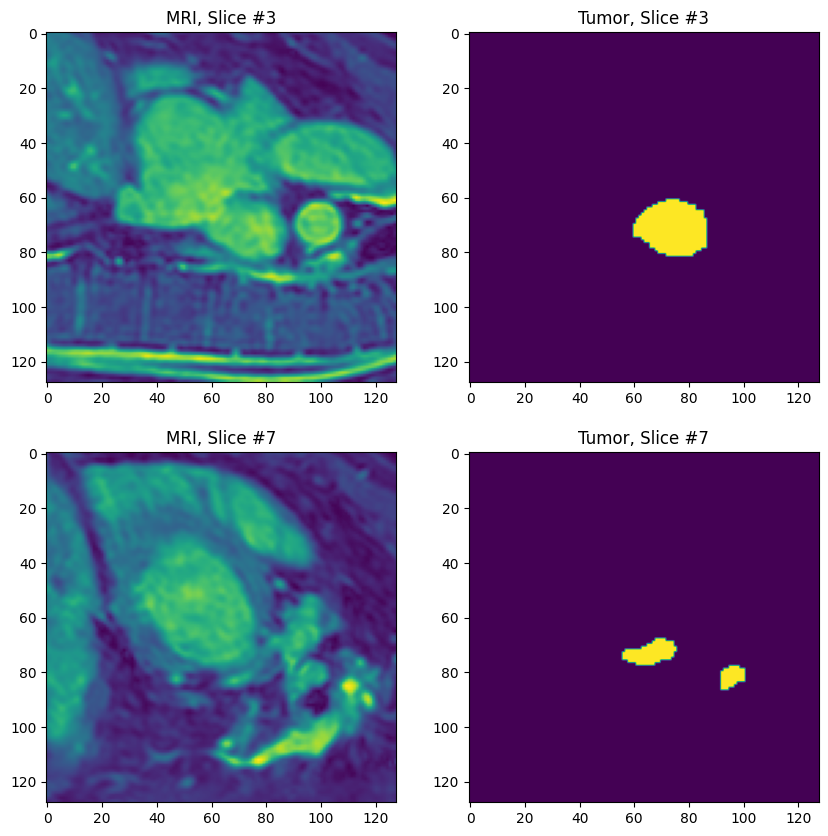

In [ ]:
ds_train.plot_samples()

In [ ]:
ds_train.get_input_shape()

[128, 128, 1]

In [ ]:
print("-" * 30)
print("Creating and compiling model ...")
print("-" * 30)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

model = MedT(img_size = crop_dim, imgchan = 1)
if device=='cuda' and torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  model = nn.DataParallel(model,device_ids=[0,1]).cuda()
model.to(device)

------------------------------
Creating and compiling model ...
------------------------------
device: cuda


medt_net(
  (conv1): Conv2d(1, 8, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (conv2): Conv2d(8, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv3): Conv2d(128, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): AxialBlock_dynamic(
      (conv_down): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (hight_block): AxialAttention_dynamic(
        (qkv_transform): qkv_transform(16, 32, kernel_size=(1,), stride=(1,), bias=False)
        (bn_qkv): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=Tru

In [ ]:
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, channel=1):
        super(DiceLoss, self).__init__()
        self.channel = channel

    def forward(self, predicted, target):
        predicted = torch.sigmoid(predicted[:, self.channel, :, :])
        target = target[:,:,:,0]
        predicted = predicted.reshape(predicted.size(0), -1)
        target = target.reshape(target.size(0), -1)

        intersection = (predicted * target).sum(dim=1)
        union = predicted.sum(dim=1) + target.sum(dim=1)
        dice_score = (2. * intersection + 1e-6) / (union + 1e-6)

        #dice_score = torch.where(union > 0, dice_score, torch.ones_like(dice_score))

        return 1 - dice_score.mean()


def dice_coefficient(predicted, target, log=False):
    predicted = torch.sigmoid(predicted[:, 1, :, :])  # Get the probabilities for the foreground class
    target = target[:,:,:,0]
    predicted = predicted.reshape(predicted.size(0), -1)
    target = target.reshape(target.size(0), -1)

    intersection = (predicted * target).sum(dim=1)
    union = predicted.sum(dim=1) + target.sum(dim=1)
    dice_score = (2. * intersection + 1e-6) / (union + 1e-6)

    # Handle the case where both predicted and target are all zeros
    #dice_score = torch.where(union > 0, dice_score, torch.ones_like(dice_score))

    if log == True:
        print(f'target: {target.sum(dim=1)}')
        print(f'predicted: {predicted.sum(dim=1)}')
        print(f'union: {union}')
        print(f'intersection: {intersection}')

    return dice_score.mean()

In [ ]:
def train(model, lr, train_data, valid_data, num_epoch, save_freq):

  criterion = DiceLoss()
  optimizer = torch.optim.Adam(list(model.parameters()), lr=lr,
                               weight_decay=1e-5)

  pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print("Total_params: {}".format(pytorch_total_params))

  seed = 3000
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  # torch.set_deterministic(True)
  # random.seed(seed)


  for epoch in range(num_epoch):

      epoch_running_loss = 0

      for batch_idx, (X_batch, y_batch, *rest) in enumerate(train_data):

          X_batch = Variable(torch.from_numpy(np.transpose(X_batch, (0, 3, 1, 2))).to(device))
          y_batch = Variable(torch.from_numpy(y_batch).to(device))

          # ===================forward=====================

          output = model(X_batch)
          tmp2 = y_batch.detach().cpu().numpy()
          tmp = output.detach().cpu().numpy()
          tmp[tmp>=0.5] = 1
          tmp[tmp<0.5] = 0
          tmp2[tmp2>0] = 1
          tmp2[tmp2<=0] = 0
          tmp2 = tmp2.astype(int)
          tmp = tmp.astype(int)

          yHaT = tmp
          yval = tmp2

          loss = criterion(output, y_batch)

          # ===================backward====================
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          epoch_running_loss += loss.item()

      # ===================log========================
      print('epoch [{}/{}], loss:{:.4f}'
            .format(epoch, num_epoch, epoch_running_loss/(batch_idx+1)))


      if epoch == 10:
        for param in model.parameters():
          param.requires_grad =True
      if (epoch % save_freq) ==0:

          for batch_idx, (X_batch, y_batch, *rest) in enumerate(valid_data):

              image_filename = '%s.png' % str(batch_idx + 1).zfill(3)

              X_batch = Variable(torch.from_numpy(np.transpose(X_batch, (0, 3, 1, 2))).to(device))
              y_batch = Variable(torch.from_numpy(y_batch).to(device))

              y_out = model(X_batch)


              tmp2 = y_batch.detach().cpu().numpy()
              tmp = y_out.permute(0,2,3,1).detach().cpu().numpy()
              tmp[tmp>=0.5] = 1
              tmp[tmp<0.5] = 0
              tmp2[tmp2>0] = 1
              tmp2[tmp2<=0] = 0
              tmp2 = tmp2.astype(int)
              tmp = tmp.astype(int)


              yHaT = tmp
              yval = tmp2

              epsilon = 1e-20

              del X_batch, y_batch,tmp,tmp2, y_out


              yHaT[yHaT==1] =255
              yval[yval==1] =255
              fulldir = "medt/diceloss4"+"/{}/".format(epoch)
              # print(fulldir+image_filename)
              if not os.path.isdir(fulldir):

                  os.makedirs(fulldir)

              cv2.imwrite(fulldir+image_filename, yHaT[-1,:,:,1])
              cv2.imwrite(fulldir+'/gt_{}.png'.format(batch_idx + 1), yval[-1,:,:,0])
          fulldir = "medt/diceloss4"+"/{}/".format(epoch)
          torch.save(model.state_dict(), fulldir+"MedT"+".pth")
          torch.save(model.state_dict(), "medt/diceloss4/" + "final_model.pth")

In [ ]:
train(model, lr=0.001, train_data=ds_train, valid_data=ds_validation, num_epoch=20, save_freq=2)

Total_params: 1553060
epoch [0/20], loss:0.8087
epoch [1/20], loss:0.7788
epoch [2/20], loss:0.7652
epoch [3/20], loss:0.7395
epoch [4/20], loss:0.7060
epoch [5/20], loss:0.6737
epoch [6/20], loss:0.5096
epoch [7/20], loss:0.5937
epoch [8/20], loss:0.5855
epoch [9/20], loss:0.5808
epoch [10/20], loss:0.5666
epoch [11/20], loss:0.5660
epoch [12/20], loss:0.5666
epoch [13/20], loss:0.5755
epoch [14/20], loss:0.5814
epoch [15/20], loss:0.5843
epoch [16/20], loss:0.5790
epoch [17/20], loss:0.6032
epoch [18/20], loss:0.5790
epoch [19/20], loss:0.5767


In [ ]:
# when cuda memory error occurs

import gc
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
loaddirec = "medt/diceloss4/final_model.pth"
model.load_state_dict(torch.load(loaddirec))

<All keys matched successfully>

In [ ]:
ds_validation = DatasetGenerator(validateFiles,
                                 batch_size=batch_size,
                                 crop_dim=[crop_dim, crop_dim],
                                 augment=False,
                                 seed=seed)

In [ ]:
def dice_coefficient(predicted, target, log=False, channel=1):
    predicted = torch.sigmoid(predicted[:, channel, :, :])  # Get the probabilities for the foreground class
    predicted = (predicted > 0.5).float()
    predicted = predicted.view(predicted.size(0), -1)
    target = target.reshape(target.size(0), -1)

    intersection = (predicted * target).sum(dim=1)
    union = predicted.sum(dim=1) + target.sum(dim=1)
    dice_score = (2. * intersection + 1e-6) / (union + 1e-6)

    if log == True:
        print(f'target: {target.sum(dim=1)}')
        print(f'predicted: {predicted.sum(dim=1)}')
        print(f'union: {union}')
        print(f'intersection: {intersection}')

    return dice_score.mean()

In [ ]:
def evaluate(model, dataloader, dataset_name):
    model.eval()  # Set the model to evaluation mode

    total_dice = 0
    total_samples = 0

    for img, lb in dataloader:

        img = Variable(torch.from_numpy(np.transpose(img, (0, 3, 1, 2))).to(device))

        lb = Variable(torch.from_numpy(lb).to(device))

        with torch.no_grad():
            output = model(img)
            tmp2 = lb.detach().cpu().numpy()
            tmp = output.detach().cpu().numpy()
            tmp[tmp>=0.5] = 1
            tmp[tmp<0.5] = 0
            tmp2[tmp2>0] = 1
            tmp2[tmp2<=0] = 0
            tmp2 = tmp2.astype(int)
            tmp = tmp.astype(int)

            yHaT = tmp
            yval = tmp2
            dice_score = dice_coefficient(torch.from_numpy(yHaT), torch.from_numpy(yval))

        total_dice += dice_score.item()
        total_samples += 1

    average_dice = total_dice / total_samples
    print(f'Avg Dice Coefficient of {dataset_name}: {average_dice}')

In [ ]:
torch.cuda.empty_cache()
gc.collect()

evaluate(model, ds_train, "Train Data")
evaluate(model, ds_validation, "Val Data")
evaluate(model, ds_test, "Test Data")

Avg Dice Coefficient of Train Data: 0.4127358498381004
Avg Dice Coefficient of Val Data: 0.3269230835463689
Avg Dice Coefficient of Test Data: 0.3750000015237896
